# Home Credit Default Risk - Machine Learning Project  

## Project Overview  
This project aims to predict **loan default risk** using historical credit data provided by the **Home Credit dataset**.  
By analyzing multiple financial datasets from past loan applications, we extract insights to improve risk assessment and minimize losses for lenders.  
While this model is trained specifically on Home Credit’s dataset, the process—data collection, preprocessing, feature engineering, and modeling—can be adapted to other financial institutions.  

## Live Application Deployment  
This project is also deployed as an **interactive Angular + Flask application**, allowing users to observe real-time model inference.  
🔗 **Try it here:** [Live Loan Default Predictor](https://ai.fullstackista.com/ai-loan-default-predictor/)  

### Key Steps in the Project  
1. **Understanding the Problem** – Define the objective: predict loan default risk using Home Credit data.  
2. **Data Processing & Feature Engineering** – Process multiple datasets, clean missing values, extract features, and aggregate information.  
3. **Exploratory Data Analysis (EDA)** – Identify trends, correlations, and risk factors in loan applications.  
4. **Merging Datasets** – Integrate primary (`application_train.csv`) and secondary datasets (e.g., `bureau.csv`, `credit_card_balance.csv`) for a unified view.  
5. **Model Training & Hyperparameter Tuning** – Train and optimize models (e.g., LightGBM) for predictive performance.  
6. **Model Evaluation** – Validate performance using metrics such as AUC-ROC.  
7. **Final Prediction** – Apply the trained model to `application_test.csv` and generate predictions.  

### About This Notebook  
This notebook processes the **`credit_card_balance.csv`** dataset, which contains applicants' **credit card transactions history** and balances over time.  

Processed features will be merged into the main dataset (**`application_train.csv`**) for model training.  

## Project Notebooks  

### Main Dataset and Model Training  
- [1. Application Train (Main Dataset)](./01_application_train.ipynb)
- [2. Model Training and Final Pipeline](./02_model_training_pipeline.ipynb)  

### Secondary Datasets Processing  
- [3. Bureau Data](./03_bureau_data.ipynb)  
- [4. Bureau Balance Data](./04_bureau_balance.ipynb)  
- [5. Credit Card Balance](./05_credit_card_balance.ipynb) _(Current Notebook)_
- [6. Previous Applications](./06_previous_applications.ipynb)  
- [7. POS Cash Balance](./07_pos_cash_balance.ipynb)  
- [8. Installments Payments](./08_installments_payments.ipynb)  

### Final Prediction  
- [9. Model Predictions on Test Data](./09_model_predictions.ipynb)  
- [10. Application Test Data Processing](./10_application_test_processing.ipynb)

# Processing `credit_card_balance.csv` (Credit Card Transactions History)

## 1. Load Data (`credit_card_balance.csv`)
We start by loading the dataset and inspecting its structure to understand its key features and statistics.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# Load dataset 
df_credit_card_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/credit_card_balance.csv")

## 2. Initial Data Inspection (`credit_card_balance.csv`)
Before processing, we inspect the dataset for potential issues such as **infinite values**, **missing values**, and other inconsistencies.

### 2.1 Checking for Infinite Values  
Infinite values (e.g., `inf`, `-inf`) can break numerical calculations and should be identified before proceeding.  
The code below scans for any **positive or negative infinite values** in the dataset.  

In [3]:
# Check for infinite values
print("Checking for infinite values in dataset...")
inf_count = (df_credit_card_balance == np.inf).sum().sum()
neg_inf_count = (df_credit_card_balance == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

Checking for infinite values in dataset...
✅ No infinite values detected.


### 2.2 Checking for Missing Values (NaNs)  
Missing values (**NaNs**) can affect model performance and should be handled properly.  
Here, we count the number of missing values in each column and print the results.

In [4]:
# Check for missing values
missing_values = df_credit_card_balance.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

⚠️ Missing values detected in columns:
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
dtype: int64


### 2.3 Print Dataset Columns  
To get an overview of the dataset structure, we print the column names.  
This helps us understand the available features and identify any inconsistencies.

In [5]:
# Print column names
print(df_credit_card_balance.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')


### 2.4 Detecting Extreme Values (Outliers)  

Extreme values (**outliers**) can skew model performance and lead to **unstable predictions**.  
We detect outliers using **percentile thresholds**:  

- **Above the 99th percentile** → Very large values.  
- **Below the 1st percentile** → Very small values.  

In [6]:
# Check for extreme values using percentile-based thresholds 
print("Checking for extreme values in 'credit_card_balance' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_PREV', 'SK_ID_CURR']  
extreme_numeric_columns = df_credit_card_balance.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'credit_card_balance' dataset.")

Checking for extreme values in 'credit_card_balance' dataset using percentile thresholds...
⚠️ Columns with very large values (above 99th percentile):
AMT_BALANCE                   1505902.185
AMT_CREDIT_LIMIT_ACTUAL       1350000.000
AMT_DRAWINGS_ATM_CURRENT      2115000.000
AMT_DRAWINGS_CURRENT          2287098.315
AMT_DRAWINGS_OTHER_CURRENT    1529847.000
AMT_DRAWINGS_POS_CURRENT      2239274.160
AMT_INST_MIN_REGULARITY        202882.005
AMT_PAYMENT_CURRENT           4289207.445
AMT_PAYMENT_TOTAL_CURRENT     4278315.690
AMT_RECEIVABLE_PRINCIPAL      1472316.795
AMT_RECIVABLE                 1493338.185
AMT_TOTAL_RECEIVABLE          1493338.185
CNT_DRAWINGS_ATM_CURRENT           51.000
CNT_DRAWINGS_CURRENT              165.000
CNT_DRAWINGS_OTHER_CURRENT         12.000
CNT_DRAWINGS_POS_CURRENT          165.000
CNT_INSTALMENT_MATURE_CUM         120.000
SK_DPD                           3260.000
SK_DPD_DEF                       3260.000
dtype: float64
⚠️ Columns with very small values (b

### 2.5 Checking Dataset Shape  

The dataset's shape provides a quick view of its size, showing the number of **rows** (loan records) and **columns** (features).  

In [7]:
# Check the shape of the dataset
print("DataFrame Shape:", df_credit_card_balance.shape)

DataFrame Shape: (3840312, 23)


### 2.6 Viewing Sample Data (`head()`)  

To understand the dataset, we display the **first few rows**.  
This helps verify that data is loaded correctly and gives an initial sense of feature distributions.  

In [8]:
# Display first few rows of the dataset
print("First few rows of credit_card_balance DataFrame:")
display(df_credit_card_balance.head())

First few rows of credit_card_balance DataFrame:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


### 2.7 Dataset Summary (`info()`)  

The `info()` function provides:  
- **Column names and types** (e.g., integer, float, categorical).  
- **Non-null counts** (to check for missing data).  
- **Memory usage**, which is useful for optimizing performance.  

In [9]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_credit_card_balance.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_I

### 2.8 Descriptive Statistics  

We generate summary statistics for:  
- **Numeric columns** (`describe()`) → Mean, standard deviation, min/max, and quartiles.  
- **Categorical columns** (`describe(include='object')`) → Count of unique values, most frequent categories.  
This helps in **understanding distributions** and identifying possible anomalies.  

In [10]:
# Get summary statistics of numeric columns
print("Descriptive Statistics:")
display(df_credit_card_balance.describe())
display(df_credit_card_balance.describe(include="object"))

Descriptive Statistics:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


,NAME_CONTRACT_STATUS
count,3840312
unique,7
top,Active
freq,3698436


In [11]:
# Analyze categorical values in NAME_CONTRACT_STATUS
print("Unique values in NAME_CONTRACT_STATUS:")
print(df_credit_card_balance["NAME_CONTRACT_STATUS"].value_counts())

# Check the percentage distribution of each category
print("Percentage distribution of NAME_CONTRACT_STATUS:")
print(df_credit_card_balance["NAME_CONTRACT_STATUS"].value_counts(normalize=True) * 100)


Unique values in NAME_CONTRACT_STATUS:
NAME_CONTRACT_STATUS
Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: count, dtype: int64
Percentage distribution of NAME_CONTRACT_STATUS:
NAME_CONTRACT_STATUS
Active           96.305613
Completed         3.356967
Signed            0.287945
Demand            0.035544
Sent proposal     0.013358
Refused           0.000443
Approved          0.000130
Name: proportion, dtype: float64


## 3. Initial Data Cleaning (`credit_card_balance.csv`)
After identifying potential issues, we clean the dataset by handling **infinite values, categorical features, and potential misclassified columns**.

### 3.1 Replacing Infinite Values  
Since infinite values (`inf`, `-inf`) can interfere with model training, we replace them with `NaN` to handle them properly later.  

In [12]:
# Replace infinite values with NaN before handling missing values
df_credit_card_balance.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


### 3.2 Converting Categorical Features  
Some columns are stored as `object` or numeric types but should be categorical.  
We identify and convert relevant columns to the **category dtype** for efficiency and proper encoding.  

In [13]:
# Convert manually identified categorical columns
categorical_cols = ["NAME_CONTRACT_STATUS"]
df_credit_card_balance[categorical_cols] = df_credit_card_balance[categorical_cols].astype("category")

print("✅ Converted manually identified categorical columns to 'category'.")

✅ Converted manually identified categorical columns to 'category'.


### 3.3 Checking Unique Values in Categorical Columns  
To ensure correct data types, we print the number of unique values in categorical columns.  
This helps verify if any unexpected categories exist.  

In [14]:
# Check unique values in categorical columns
print("Unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_credit_card_balance[col].nunique()} unique values")

Unique values in categorical columns:
NAME_CONTRACT_STATUS: 7 unique values


### 3.4 Checking Decimal Values in Float Columns  

Some columns are stored as floats but should contain only **integer values** (e.g., counts of transactions or installments).  
To verify correctness, we check how many rows in each float column contain non-integer (decimal) values.  
This helps detect potential **data type mismatches** or **unexpected floating-point precision issues**.  

In [15]:
# Check if float columns contain decimal values
print("\nChecking if float columns contain decimal values:")

# Identify all float columns
float_cols = df_credit_card_balance.select_dtypes(include=['float']).columns

# Count the number of rows in each float column that contain decimal values
decimal_counts = df_credit_card_balance[float_cols].map(lambda x: x % 1 != 0).sum()

# Print results
print(decimal_counts)


Checking if float columns contain decimal values:
AMT_BALANCE                   1663512
AMT_DRAWINGS_ATM_CURRENT       750501
AMT_DRAWINGS_CURRENT           215602
AMT_DRAWINGS_OTHER_CURRENT     752403
AMT_DRAWINGS_POS_CURRENT       956281
AMT_INST_MIN_REGULARITY        850035
AMT_PAYMENT_CURRENT           2078342
AMT_PAYMENT_TOTAL_CURRENT      388822
AMT_RECEIVABLE_PRINCIPAL      1475061
AMT_RECIVABLE                 1704447
AMT_TOTAL_RECEIVABLE          1704472
CNT_DRAWINGS_ATM_CURRENT       749816
CNT_DRAWINGS_OTHER_CURRENT     749816
CNT_DRAWINGS_POS_CURRENT       749816
CNT_INSTALMENT_MATURE_CUM      305236
dtype: int64


### 3.5 Extracting Unique Decimal Values  

To further investigate potential **data type mismatches**, we extract and display **unique decimal values** in float columns.  
This helps confirm whether numerical features expected to be integers contain unintended floating-point values.  

In [16]:
# Extract unique decimal values
print("\nChecking unique decimal values:")
for col in float_cols:
    unique_decimals = df_credit_card_balance[col].dropna().map(lambda x: x % 1).unique()
    print(f"{col}: {unique_decimals}")


Checking unique decimal values:
AMT_BALANCE: [0.97  0.555 0.225 ... 0.93  0.955 0.775]
AMT_DRAWINGS_ATM_CURRENT: [0.    0.09  0.82  0.58  0.97  0.125 0.875 0.1   0.465 0.38  0.455 0.09
 0.155 0.995 0.69  0.365 0.5   0.145 0.065 0.44  0.505 0.525 0.57  0.095
 0.815 0.555 0.64  0.23  0.825 0.6   0.475 0.25  0.535 0.11  0.625 0.955
 0.715 0.505 0.69  0.775 0.645 0.35  0.455 0.24  0.18  0.14  0.94  0.605
 0.49  0.755 0.265 0.41  0.865 0.29  0.94  0.61  0.36  0.755 0.265 0.735
 0.155 0.605 0.77  0.835 0.425 0.725 0.31  0.75  0.375 0.775 0.925 0.77
 0.39  0.07  0.48  0.83  0.595 0.445 0.195 0.405 0.585 0.215 0.05  0.465
 0.76  0.45  0.825 0.89  0.18  0.695 0.825 0.35  0.175 0.01  0.025 0.13
 0.14  0.905 0.645 0.01  0.325 0.2   0.845 0.53  0.975 0.755 0.63  0.08
 0.765 0.63  0.535 0.23  0.47  0.23  0.98  0.78  0.08  0.135 0.85  0.035
 0.99  0.64  0.925 0.17  0.85  0.355 0.79  0.52  0.4   0.695 0.91  0.51
 0.525 0.47  0.385 0.43  0.13  0.15  0.95  0.115 0.365 0.255 0.015 0.38
 0.66  0.35  0.3

### 3.6 Converting Count-Based Columns to Integers  

Certain columns represent **count-based features**, but they may be mistakenly stored as floats.  
To ensure consistency, we convert these columns to **integer type**, preserving numerical integrity.  

In [17]:
# Convert count-based columns to integers
cnt_columns = ['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']
df_credit_card_balance[cnt_columns] = df_credit_card_balance[cnt_columns].astype('Int64')

print("✅ Converted CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, and CNT_INSTALMENT_MATURE_CUM to integers.")

✅ Converted CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, and CNT_INSTALMENT_MATURE_CUM to integers.


### 3.7 Displaying Updated Data Types  

After data cleaning, we check if all columns have the correct data types.  
This ensures that categorical, numeric, and ID columns are properly assigned before further processing.  

In [18]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_credit_card_balance.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types:
SK_ID_PREV                       int64
SK_ID_CURR                       int64
MONTHS_BALANCE                   int64
AMT_BALANCE                    float64
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float64
AMT_DRAWINGS_CURRENT           float64
AMT_DRAWINGS_OTHER_CURRENT     float64
AMT_DRAWINGS_POS_CURRENT       float64
AMT_INST_MIN_REGULARITY        float64
AMT_PAYMENT_CURRENT            float64
AMT_PAYMENT_TOTAL_CURRENT      float64
AMT_RECEIVABLE_PRINCIPAL       float64
AMT_RECIVABLE                  float64
AMT_TOTAL_RECEIVABLE           float64
CNT_DRAWINGS_ATM_CURRENT         Int64
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT       Int64
CNT_DRAWINGS_POS_CURRENT         Int64
CNT_INSTALMENT_MATURE_CUM        Int64
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
dtype: object


### 3.8 Handling Missing Values  
Missing values can impact model performance, so we analyze and handle them based on their percentage.  

#### 3.8.1 Checking for Missing Values  
We first identify missing values in each column to understand their distribution.  

In [19]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("Missing values in each column:")
print(df_credit_card_balance.isnull().sum())
pd.reset_option('display.max_rows')

Missing values in each column:
SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64


#### 3.8.2 Calculating Missing Value Percentages  
To categorize missing values, we define thresholds:  
- **Low**: Less than 1% missing (likely safe to fill with median/mean).  
- **Moderate**: 1%–20% missing (requires careful handling).  
- **High**: More than 50% missing (usually dropped unless critical).  

In [20]:
# Define missing value thresholds 
low_threshold = 1  # Less than 1% missing
moderate_threshold = 20  # Between 1% and 20% missing
high_threshold = 50  # More than 50% missing 

# Calculate missing value percentage
missing_percent = (df_credit_card_balance.isnull().sum() / len(df_credit_card_balance)) * 100  

# Display missing percentages
print("Missing Value Percentages:")
display(missing_percent[missing_percent > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")) 

Missing Value Percentages:


AMT_PAYMENT_CURRENT           20.00%
AMT_DRAWINGS_ATM_CURRENT      19.52%
AMT_DRAWINGS_OTHER_CURRENT    19.52%
AMT_DRAWINGS_POS_CURRENT      19.52%
CNT_DRAWINGS_ATM_CURRENT      19.52%
CNT_DRAWINGS_OTHER_CURRENT    19.52%
CNT_DRAWINGS_POS_CURRENT      19.52%
AMT_INST_MIN_REGULARITY        7.95%
CNT_INSTALMENT_MATURE_CUM      7.95%
dtype: object

### 3.9 Filling Missing Values  

To ensure data completeness, we fill missing values in both **numeric** and **categorical** columns using appropriate strategies.  
- **Numeric values** → Filled with **median** (robust to outliers).  
- **Categorical values** → Filled with **mode** (most frequent category).  

In [21]:
# Fill numeric columns with median
numeric_cols_to_fill = df_credit_card_balance.select_dtypes(include=['int64', 'float64']).columns
df_credit_card_balance[numeric_cols_to_fill] = df_credit_card_balance[numeric_cols_to_fill].fillna(df_credit_card_balance[numeric_cols_to_fill].median())

print("✅ Filled numeric missing values with median.")

✅ Filled numeric missing values with median.


### 3.10 Final Missing Values Check  
After filling missing values, we perform a final check to confirm that **no NaNs remain** in the dataset.  

In [22]:
# Final Missing Values Check
print("Final Missing Values Check:")
print(df_credit_card_balance.isnull().sum().sum())

Final Missing Values Check:
0


### 3.11 Checking for Duplicates  
Duplicate rows can cause data leakage and distort model training.  
We check for duplicates and ensure that no redundant rows exist.  

In [23]:
# Check for duplicates
print("Checking for duplicate rows...")
print("Number of duplicate rows:", df_credit_card_balance.duplicated().sum())

Checking for duplicate rows...
Number of duplicate rows: 0


### 3.12 Saving the Cleaned Dataset  

Before saving, we **verify all column data types** to ensure correctness after processing.  

We save the cleaned dataset for the following purpose:  

**Feature Ranges for Dummy Data** → This dataset is later used in the **Angular + Flask app** to generate test data for predictions.  

In [24]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types for df_credit_card_balance:")
print(df_credit_card_balance.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types for df_credit_card_balance:
SK_ID_PREV                       int64
SK_ID_CURR                       int64
MONTHS_BALANCE                   int64
AMT_BALANCE                    float64
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float64
AMT_DRAWINGS_CURRENT           float64
AMT_DRAWINGS_OTHER_CURRENT     float64
AMT_DRAWINGS_POS_CURRENT       float64
AMT_INST_MIN_REGULARITY        float64
AMT_PAYMENT_CURRENT            float64
AMT_PAYMENT_TOTAL_CURRENT      float64
AMT_RECEIVABLE_PRINCIPAL       float64
AMT_RECIVABLE                  float64
AMT_TOTAL_RECEIVABLE           float64
CNT_DRAWINGS_ATM_CURRENT         Int64
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT       Int64
CNT_DRAWINGS_POS_CURRENT         Int64
CNT_INSTALMENT_MATURE_CUM        Int64
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
dtype: object


In [25]:
df_credit_card_balance.to_csv("cleaned_credit_card_balance.csv")
df_credit_card_balance.to_pickle("cleaned_credit_card_balance.pkl")

print("✅ Cleaned Credit Card Balance dataset saved successfully!")

✅ Cleaned Credit Card Balance dataset saved successfully!


## 4. Exploratory Data Analysis (`credit_card_balance.csv`)

EDA helps us **understand data distributions, correlations, and patterns** that might impact feature engineering.  

### 4.1 Summary Statistics  

We first generate summary statistics for both **numeric** and **categorical features** to check distributions, outliers, and data consistency.  

In [26]:
### Summary Statistics
pd.set_option('display.max_columns', None)

# Numeric summary
print("Summary Statistics (Numeric Features):")
display(df_credit_card_balance.describe().T)

# Categorical summary
print("Summary Statistics (Categorical Features):")
display(df_credit_card_balance.describe(include=["category"]).T)

pd.reset_option('display.max_columns')

Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,3840312.0,1904503.5899,536469.470563,1000018.0,1434385.0,1897122.0,2369327.75,2843496.0
SK_ID_CURR,3840312.0,278324.207289,102704.475133,100006.0,189517.0,278396.0,367580.0,456250.0
MONTHS_BALANCE,3840312.0,-34.521921,26.667751,-96.0,-55.0,-28.0,-11.0,-1.0
AMT_BALANCE,3840312.0,58300.155262,106307.031025,-420250.185,0.0,0.0,89046.68625,1505902.185
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,153807.9574,165145.699523,0.0,45000.0,112500.0,180000.0,1350000.0
AMT_DRAWINGS_ATM_CURRENT,3840312.0,4797.383785,25430.70437,-6827.31,0.0,0.0,0.0,2115000.0
AMT_DRAWINGS_CURRENT,3840312.0,7433.388179,33846.077334,-6211.62,0.0,0.0,0.0,2287098.315
AMT_DRAWINGS_OTHER_CURRENT,3840312.0,231.90484,7358.721299,0.0,0.0,0.0,0.0,1529847.0
AMT_DRAWINGS_POS_CURRENT,3840312.0,2389.149503,18693.534956,0.0,0.0,0.0,0.0,2239274.16
AMT_INST_MIN_REGULARITY,3840312.0,3258.821327,5457.655789,0.0,0.0,0.0,5625.0,202882.005


Summary Statistics (Categorical Features):


,count,unique,top,freq
NAME_CONTRACT_STATUS,3840312,7,Active,3698436


### 4.2 Correlation Analysis  

We calculate feature correlations to detect **strongly related variables**.  
This helps identify **redundant features** and potential **new interactions** for modeling.  

In [27]:
# Select only numeric columns from df_credit_card_balance
numeric_data = df_credit_card_balance.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Display top 10 most correlated feature pairs (excluding self-correlations)
print("🔍 Top 10 Most Correlated Features in `df_credit_card_balance`:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
print(corr_pairs.head(10))

🔍 Top 10 Most Correlated Features in `df_credit_card_balance`:
AMT_RECIVABLE             AMT_TOTAL_RECEIVABLE        0.999995
AMT_TOTAL_RECEIVABLE      AMT_RECIVABLE               0.999995
AMT_BALANCE               AMT_RECIVABLE               0.999917
AMT_RECIVABLE             AMT_BALANCE                 0.999917
AMT_TOTAL_RECEIVABLE      AMT_BALANCE                 0.999897
AMT_BALANCE               AMT_TOTAL_RECEIVABLE        0.999897
AMT_RECIVABLE             AMT_RECEIVABLE_PRINCIPAL    0.999727
AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE               0.999727
AMT_BALANCE               AMT_RECEIVABLE_PRINCIPAL    0.999720
AMT_RECEIVABLE_PRINCIPAL  AMT_BALANCE                 0.999720
dtype: float64


### Key Takeaways:  
- **Near-perfect correlations (~1.0)** exist between `AMT_RECEIVABLE`, `AMT_TOTAL_RECEIVABLE`, and `AMT_BALANCE`, indicating potential redundancy.  
- These features likely represent variations of the same underlying concept and could be **combined or one may be dropped** to reduce multicollinearity.  
- Correlations close to **1.0 suggest duplicated information**, which could impact model performance if not handled.  

### 4.3 Correlation Heatmap  

We visualize the correlation matrix using a **heatmap** to detect strongly related features.  
This helps identify **redundant features** and possible **new interactions** for modeling.  

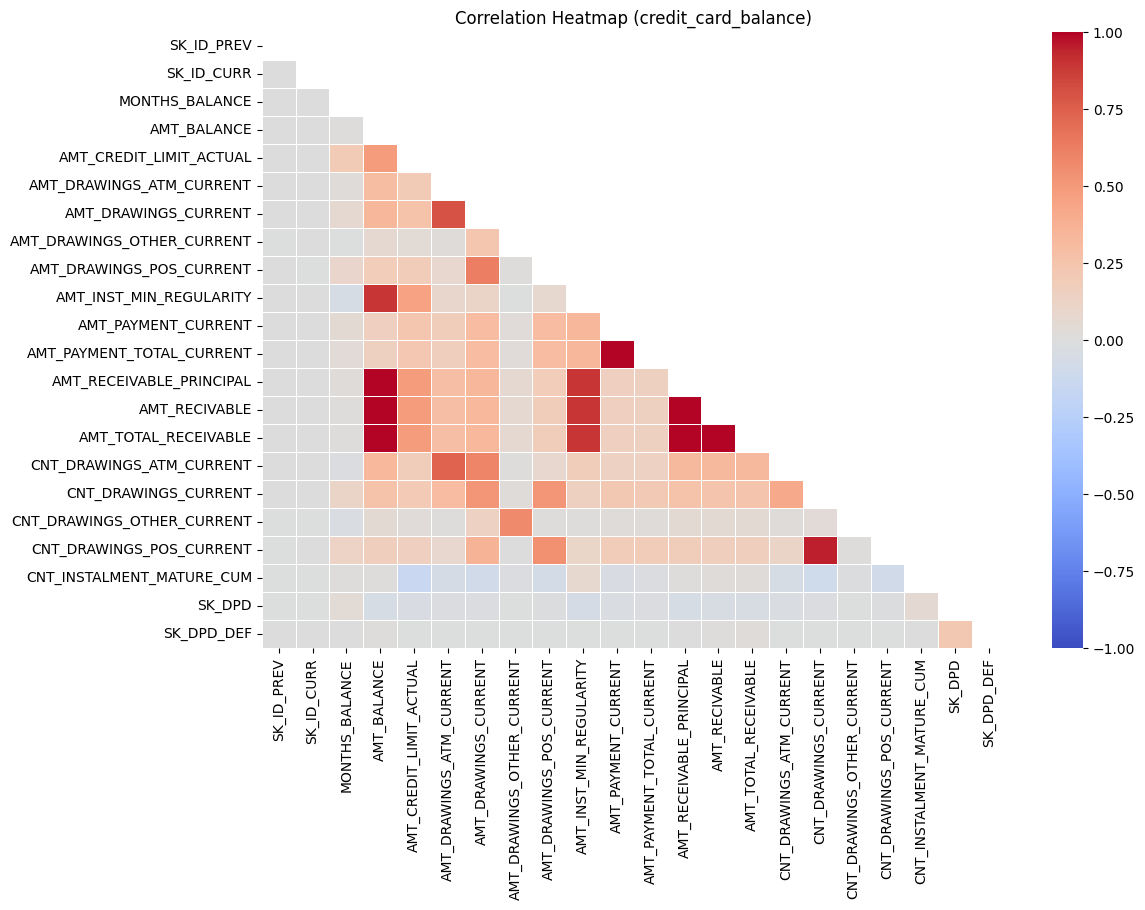

In [28]:
# Visualize the correlation matrix using a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False,  # Remove annotation for readability
    cmap="coolwarm", 
    linewidths=0.5, 
    vmin=-1, vmax=1  # Standardize color scale
)

# Title
plt.title("Correlation Heatmap (credit_card_balance)")
plt.show()

### Key Takeaways:
- **Strong correlations** exist between `AMT_RECIVABLE`, `AMT_TOTAL_RECEIVABLE`, and `AMT_RECEIVABLE_PRINCIPAL`, suggesting they might contain redundant information.
- **Moderate correlation** is observed in payment-related features (`AMT_PAYMENT_CURRENT`, `AMT_PAYMENT_TOTAL_CURRENT`), indicating potential overlapping information.
- **Weak correlations** across other features suggest minimal direct linear relationships, but they may still contribute useful patterns in non-linear models.
- **Feature selection** may be needed to reduce redundancy and improve model efficiency.

### 4.4 Visualizing Outliers  

We plot boxplots of key numerical features to detect **potential extreme values**.  
Since LightGBM handles outliers efficiently, **no transformations** are applied.  

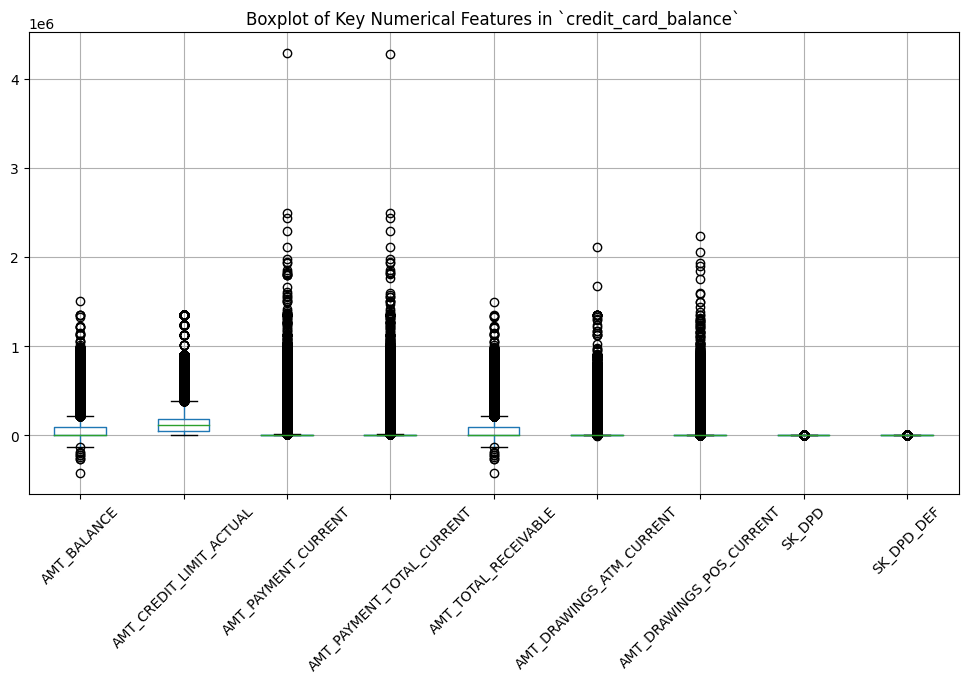

In [29]:
# Selected key numeric features for outlier detection
outlier_columns = [
    "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL", "AMT_PAYMENT_CURRENT", 
    "AMT_PAYMENT_TOTAL_CURRENT", "AMT_TOTAL_RECEIVABLE", 
    "AMT_DRAWINGS_ATM_CURRENT", "AMT_DRAWINGS_POS_CURRENT", 
    "SK_DPD", "SK_DPD_DEF"
]

# Create boxplot
plt.figure(figsize=(12, 6))
df_credit_card_balance[outlier_columns].boxplot()

# Title
plt.title("Boxplot of Key Numerical Features in `credit_card_balance`")
plt.xticks(rotation=45)  
plt.show()

### Key Takeaways:
- `AMT_BALANCE`, `AMT_CREDIT_LIMIT_ACTUAL`, and `AMT_PAYMENT_TOTAL_CURRENT` exhibit **significant outliers**, likely representing high credit limits and large repayments.
- Outliers are expected in financial transactions but may still **affect certain models** (e.g., linear models).
- **No transformations** are applied, as LightGBM is robust to outliers, but feature scaling may be needed for alternative models.

### 4.5 Pair Plot Analysis

Pair plots help visualize relationships between multiple numerical features.
- Scatter plots show relationships between feature pairs.
- Histograms along the diagonal show feature distributions.

To improve performance, we sample 10,000 rows from the dataset.

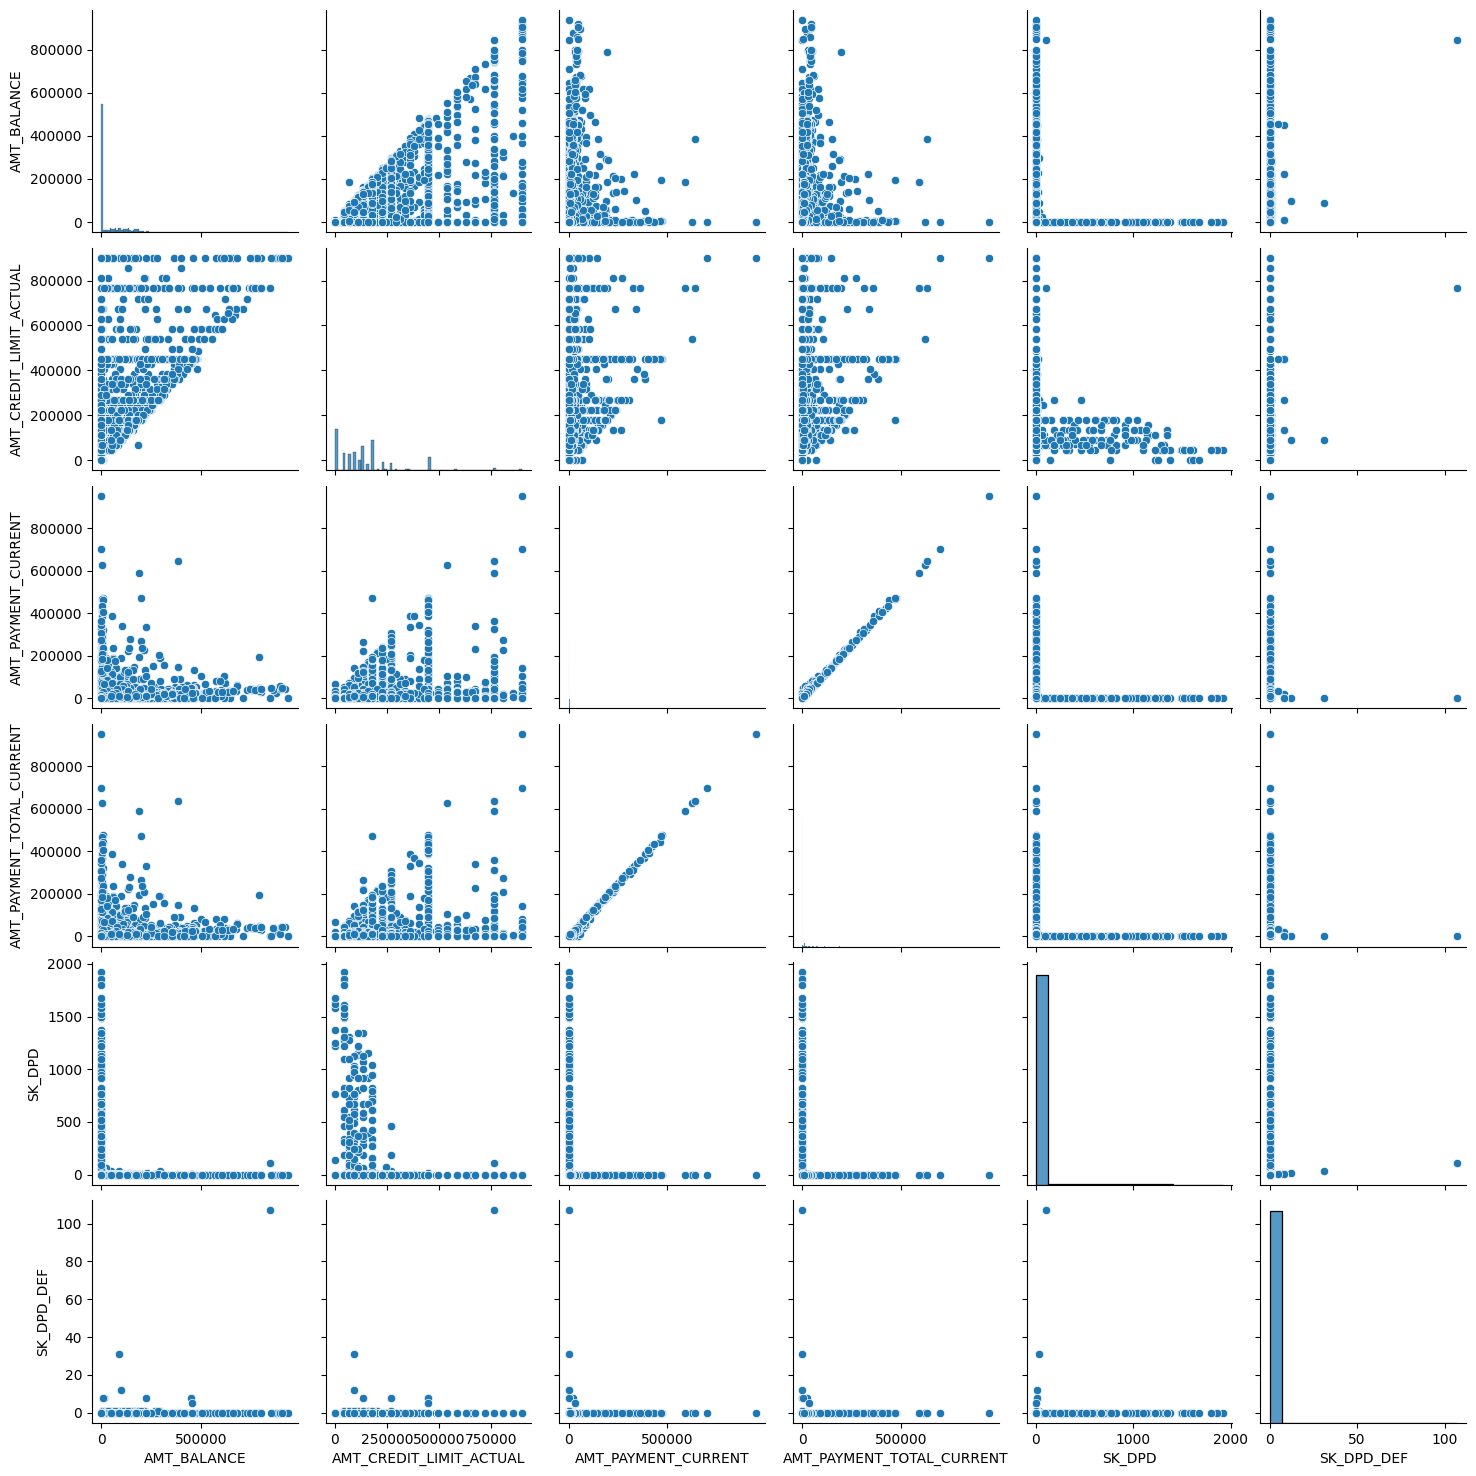

In [30]:
# Selected key numerical features for pair plot
numeric_features = [
    "AMT_BALANCE", 
    "AMT_CREDIT_LIMIT_ACTUAL", 
    "AMT_PAYMENT_CURRENT", 
    "AMT_PAYMENT_TOTAL_CURRENT", 
    "SK_DPD", 
    "SK_DPD_DEF"
]

# Reduce dataset to 10,000 rows for performance
df_sample = df_credit_card_balance[numeric_features].sample(n=10000, random_state=42)

# Create pair plot
sns.pairplot(df_sample)
plt.show()

### Key Takeaways:
- **Linear relationships observed** between `AMT_CREDIT_LIMIT_ACTUAL`, `AMT_PAYMENT_CURRENT`, and `AMT_PAYMENT_TOTAL_CURRENT`, indicating strong dependencies.
- `SK_DPD` and `SK_DPD_DEF` have **distinct clusters**, suggesting potential categorical-like behavior despite being numeric.
- Some features exhibit **skewed distributions**, which may require transformations depending on the model used.
- Pair plots highlight feature redundancies that can help with feature selection.

### 4.6 Group-wise Analysis

Group-wise analysis helps us understand how numerical features vary across different categorical groups.
- We examine how a numerical feature is distributed across different categorical values.
- Boxplots are used to visualize variations and identify potential trends.
- This helps detect disparities and patterns that could be relevant for further modeling.

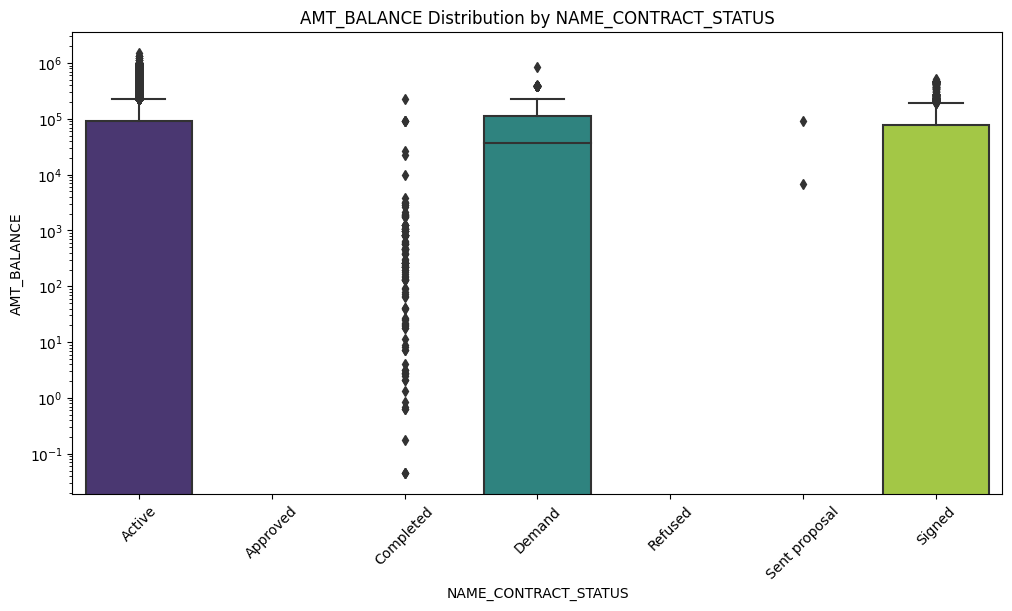

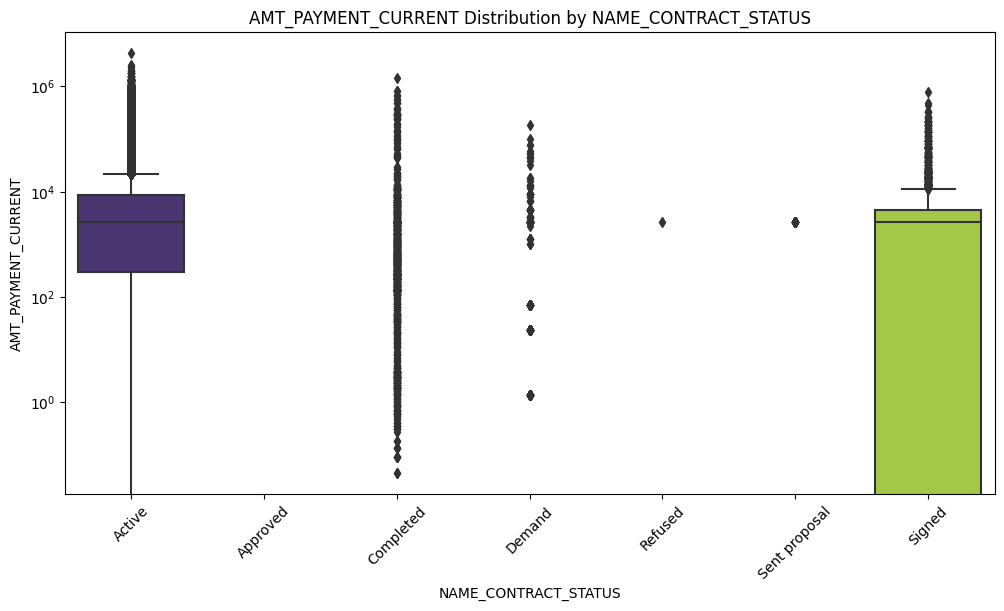

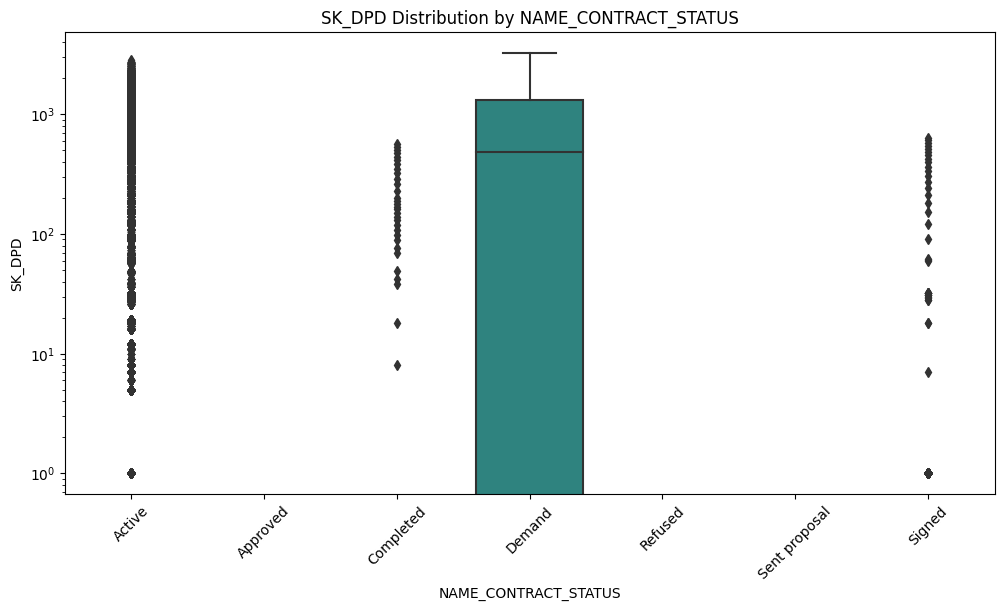

In [31]:
# Selected categorical column for group-wise analysis
categorical_col_boxplot = "NAME_CONTRACT_STATUS"

# Selected numerical columns for comparison
numeric_cols_boxplot = ["AMT_BALANCE", "AMT_PAYMENT_CURRENT", "SK_DPD"]

for numeric_col in numeric_cols_boxplot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=categorical_col_boxplot, y=numeric_col, data=df_credit_card_balance, palette="viridis", dodge=False)
    plt.title(f"{numeric_col} Distribution by {categorical_col_boxplot}")
    plt.xticks(rotation=45)
    plt.yscale("log")  # Apply log scale to handle extreme outliers
    plt.show()

### Key Takeaways:
- **Significant differences** in `AMT_BALANCE` and `AMT_PAYMENT_CURRENT` across contract statuses suggest that financial activity varies by status type.
- **Higher overdue values (`SK_DPD`)** are observed for certain statuses, indicating potential risk factors.
- The **log scale** helps visualize extreme values while maintaining interpretability.
- This analysis provides insights into financial behavior across contract categories, which may inform feature selection.

### 4.7 Time-wise Analysis
We analyze how key features evolve over time to detect **trends, seasonality, or anomalies**.  
This helps in identifying patterns that might improve feature engineering. 

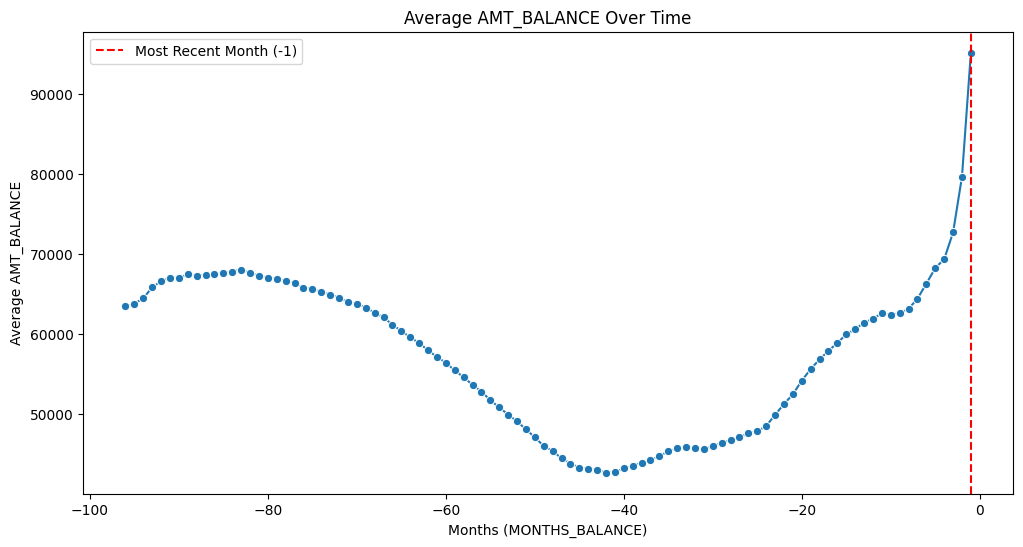

In [32]:
# Aggregate balance over time
df_balance_trend = df_credit_card_balance.groupby("MONTHS_BALANCE")["AMT_BALANCE"].mean()

# Plot balance trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_balance_trend.index, y=df_balance_trend.values, marker="o")
plt.title("Average AMT_BALANCE Over Time")
plt.xlabel("Months (MONTHS_BALANCE)")
plt.ylabel("Average AMT_BALANCE")
plt.axvline(x=-1, color="r", linestyle="--", label="Most Recent Month (-1)")
plt.legend()
plt.show()

### Key Takeaways:
- `AMT_BALANCE` shows **a cyclical trend** over time, with a **decline around -60 months**, followed by a recovery and a steep increase near the most recent recorded months.
- The observed pattern may reflect **regular credit card usage cycles**, where balances decrease as clients repay debt and increase with new expenditures.
- Understanding these trends can help refine feature engineering, especially if similar patterns exist across different client groups.

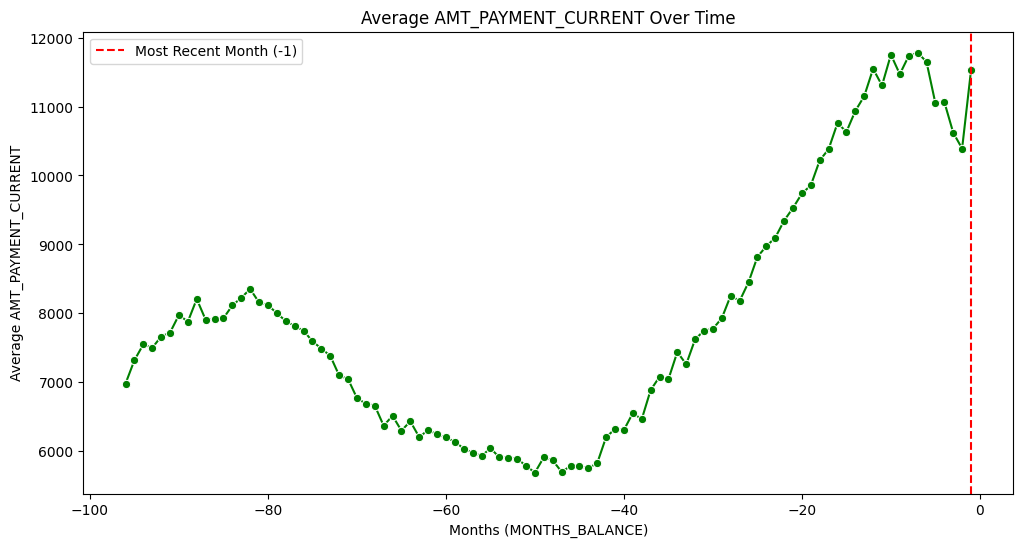

In [33]:
# Aggregate payments over time
df_payment_trend = df_credit_card_balance.groupby("MONTHS_BALANCE")["AMT_PAYMENT_CURRENT"].mean()

# Plot payment trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_payment_trend.index, y=df_payment_trend.values, marker="o", color="green")
plt.title("Average AMT_PAYMENT_CURRENT Over Time")
plt.xlabel("Months (MONTHS_BALANCE)")
plt.ylabel("Average AMT_PAYMENT_CURRENT")
plt.axvline(x=-1, color="r", linestyle="--", label="Most Recent Month (-1)")
plt.legend()
plt.show()

### Key Takeaways:
- **Payments show cyclical trends**, with a decline around -60 months and a steady rise closer to recent months.
- The peak in payments **coincides with increasing balances** in the previous plot, suggesting a structured repayment cycle.
- The most recent period (**Month -1**) shows a small drop, which could indicate **seasonal changes or repayment adjustments**.
- This dataset represents **credit card usage history**, meaning clients are in different stages of repayment.

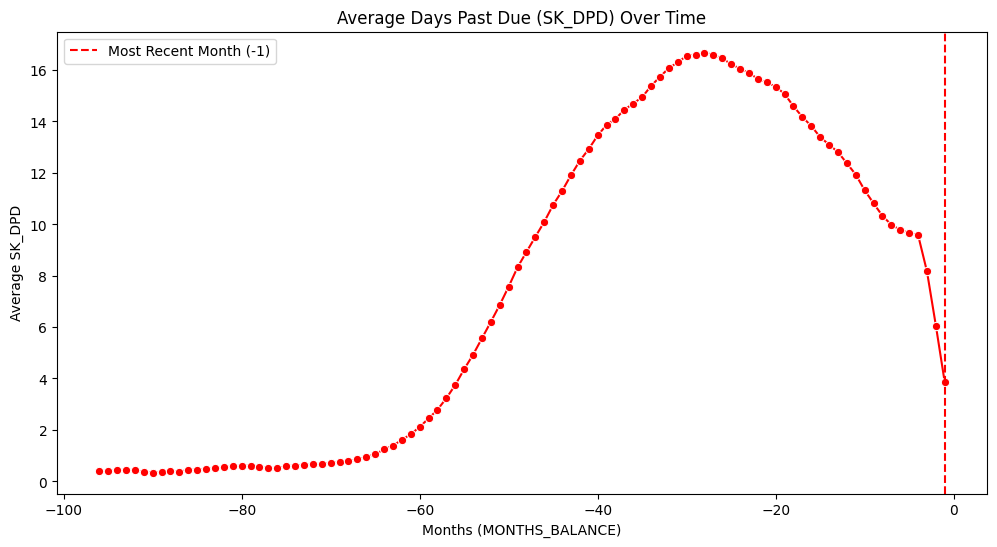

In [34]:
# Aggregate overdue trend over time
df_dpd_trend = df_credit_card_balance.groupby("MONTHS_BALANCE")["SK_DPD"].mean()

# Plot overdue trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_dpd_trend.index, y=df_dpd_trend.values, marker="o", color="red")
plt.title("Average Days Past Due (SK_DPD) Over Time")
plt.xlabel("Months (MONTHS_BALANCE)")
plt.ylabel("Average SK_DPD")
plt.axvline(x=-1, color="r", linestyle="--", label="Most Recent Month (-1)")
plt.legend()
plt.show()

### Key Takeaways:
- The **number of days past due (SK_DPD)** increased steadily over time, peaking around -30 to -40 months.
- A **recent decline** suggests either **improved repayment behavior** or **debt refinancing through longer-term loans**.
  - Banks and credit institutions often **consolidate** multiple debts into a single loan, which could reset overdue balances.
- The most recent period (**Month -1**) shows a **sharp drop in overdue days**, which could indicate:
  - Clients paying off debts more consistently.
  - A shift in the customer base (fewer delinquent borrowers).
  - External factors such as **government interventions, financial restructuring, or debt consolidation programs**.
- Further investigation is needed to confirm whether this trend is due to **actual behavioral improvements**, **refinancing effects**, or **dataset biases**.

### 4.8 Joint Plot Analysis
We use scatter plots with histograms to visualize relationships between numerical features.  
This helps identify patterns, correlations, and potential outliers.

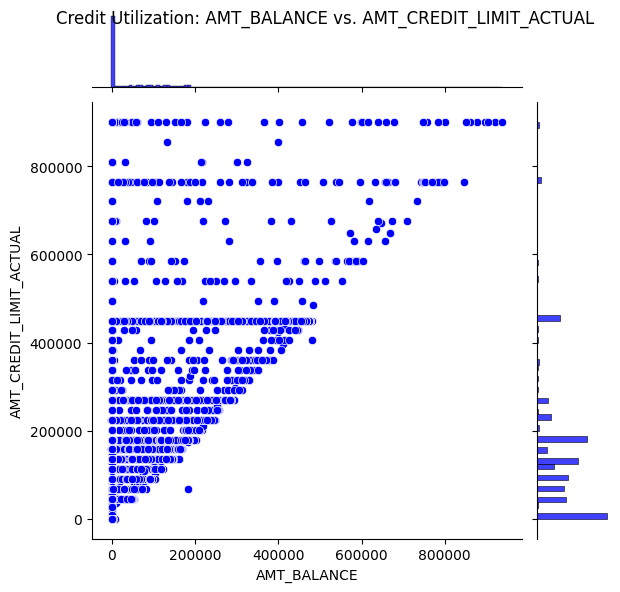

In [35]:
# Sample 10,000 rows for performance
df_sample_scatter = df_credit_card_balance.sample(n=10000, random_state=42)

# Credit Utilization vs. Balance
sns.jointplot(x="AMT_BALANCE", y="AMT_CREDIT_LIMIT_ACTUAL", data=df_sample_scatter, kind="scatter", color="blue")
plt.suptitle("Credit Utilization: AMT_BALANCE vs. AMT_CREDIT_LIMIT_ACTUAL")
plt.show()

### Key Takeaways:
- **Triangular pattern** suggests clients either **fully utilize** their credit limits or use only a fraction.
- **Credit limits appear standardized**, forming vertical clusters at common thresholds (e.g., 100k, 200k, 500k).
- **Outliers exist at high credit limits**, but they are rare.

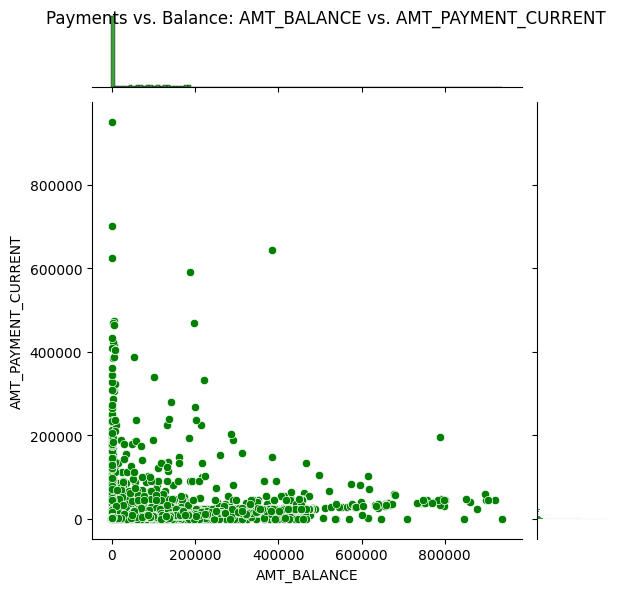

In [36]:
# Payments vs. Balance
sns.jointplot(x="AMT_BALANCE", y="AMT_PAYMENT_CURRENT", data=df_sample_scatter, kind="scatter", color="green")
plt.suptitle("Payments vs. Balance: AMT_BALANCE vs. AMT_PAYMENT_CURRENT")
plt.show()

### Key Takeaways:
- **Payments tend to be lower** for clients with higher balances, suggesting some may **carry revolving credit** rather than fully paying off debts.
- A **dense cluster near zero** indicates many clients have low balances and payments, possibly inactive or minimally used accounts.
- Some **high-payment outliers** exist, but they are relatively rare.

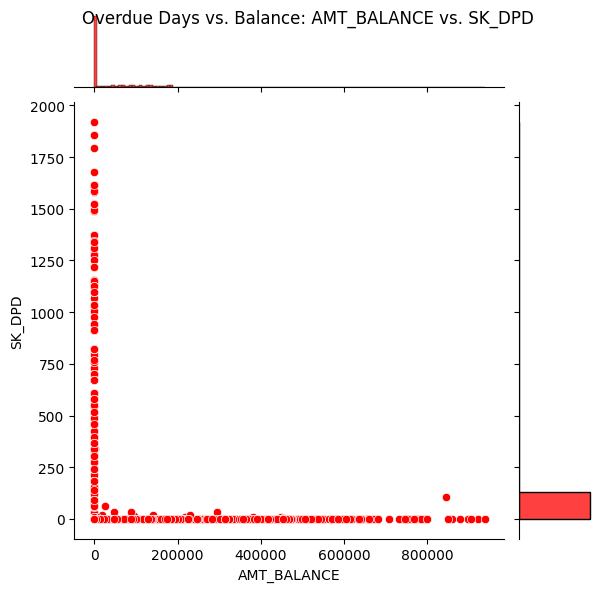

In [37]:
# Overdue Days vs. Balance
sns.jointplot(x="AMT_BALANCE", y="SK_DPD", data=df_sample_scatter, kind="scatter", color="red")
plt.suptitle("Overdue Days vs. Balance: AMT_BALANCE vs. SK_DPD")
plt.show()

### Key Takeaways:
- **Most overdue accounts** have **low or zero balances**, suggesting that many clients with overdue payments may not be actively using their credit lines.
- A **small group of high-balance accounts** also has overdue days, indicating that **some high-credit users may still struggle with timely payments**.
- The **majority of clients have zero overdue days**, reinforcing that most users make timely payments.

### 4.9 Additional EDA Visualisations

We plot histograms to visualize the distribution of key numerical features.  
This helps detect skewness, outliers, and possible data transformations.

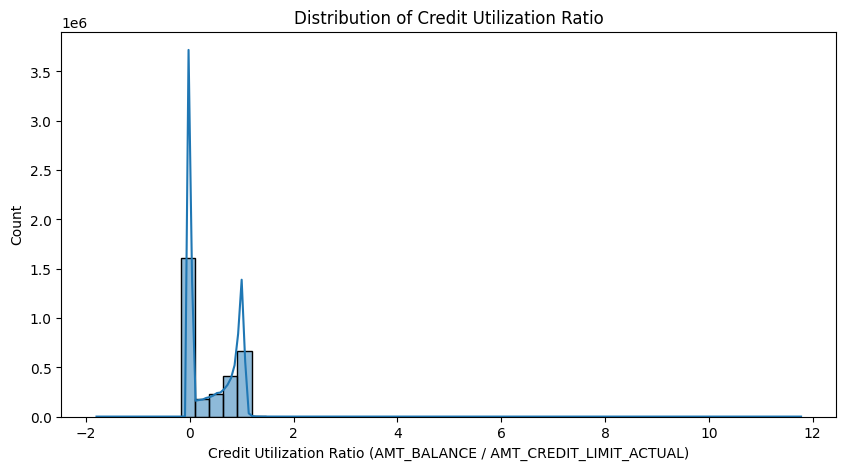

In [38]:
# Distribution of credit utilisation
plt.figure(figsize=(10, 5))
sns.histplot(df_credit_card_balance["AMT_BALANCE"] / df_credit_card_balance["AMT_CREDIT_LIMIT_ACTUAL"], bins=50, kde=True)
plt.title("Distribution of Credit Utilization Ratio")
plt.xlabel("Credit Utilization Ratio (AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL)")
plt.ylabel("Count")
plt.show()

### Key Takeaways:
- The **credit utilization ratio** (AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL) is **highly skewed**, with most values near zero.
- A **small number of clients exceed their credit limits**, possibly due to fees, interest, or policy exceptions.
- The **spikes at specific values** suggest common credit usage patterns, possibly reflecting standard credit policies or repayment structures.

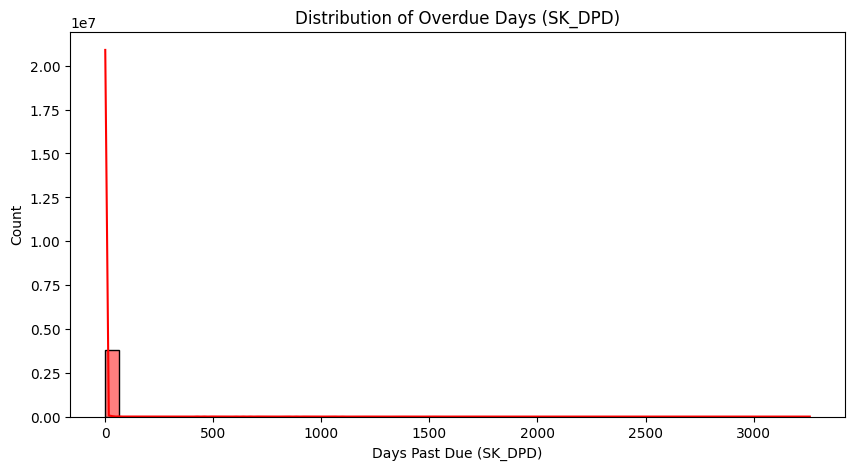

In [39]:
# Distribution of overdue days (SK_DPD)
plt.figure(figsize=(10, 5))
sns.histplot(df_credit_card_balance["SK_DPD"], bins=50, kde=True, color="red")
plt.title("Distribution of Overdue Days (SK_DPD)")
plt.xlabel("Days Past Due (SK_DPD)")
plt.ylabel("Count")
plt.show()

### Key Takeaways:
- The vast majority of **credit card balances are repaid on time**, with most values at **0 days past due**.
- A **small subset** of accounts exhibit **severe delinquencies** (hundreds or even thousands of overdue days).
- The extreme values could represent **long-term defaulters** or accounts under extended restructuring.

We analyze the distribution of key categorical features using bar plots.  
This helps identify class imbalances, dominant categories, and rare values.

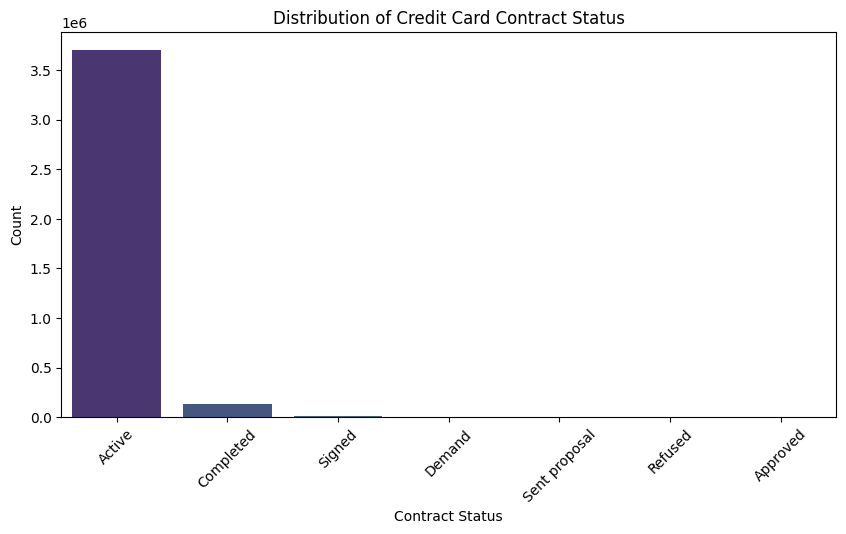

In [40]:
# Contract status distribution
plt.figure(figsize=(10, 5))
sns.countplot(x="NAME_CONTRACT_STATUS", data=df_credit_card_balance, palette="viridis", order=df_credit_card_balance["NAME_CONTRACT_STATUS"].value_counts().index)
plt.title("Distribution of Credit Card Contract Status")
plt.xlabel("Contract Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Key Takeaways:
- The majority of credit card contracts are **Active**, indicating ongoing usage.
- A small portion of contracts are **Completed**, meaning they have been fully repaid.
- Other statuses such as **Signed, Demand, Refused, and Approved** are rare, suggesting they may not be as relevant for modeling.
- The imbalance in contract statuses should be considered when using this feature in predictive models.

## 5. Feature Engineering (`credit_card_balance.csv`)
We create new features to enhance predictive power by summarizing key attributes of the dataset.  
Feature engineering helps capture meaningful patterns that might improve model performance.

### 5.1 Credit Activity Features  
Summarize the number of credit cards per client, distinguishing between active and closed accounts.

In [41]:
# 5.1 Credit Activity Features - Group by SK_ID_CURR
credit_card_activity_features = df_credit_card_balance.groupby("SK_ID_CURR").agg(
    credit_card_NUM_CREDIT_CARDS=("SK_ID_PREV", "count"),  # Total number of credit cards per client
    credit_card_NUM_ACTIVE_CARDS=("NAME_CONTRACT_STATUS", lambda x: (x == "Active").sum()),  # Count active credit cards
    credit_card_NUM_CLOSED_CARDS=("NAME_CONTRACT_STATUS", lambda x: (x == "Completed").sum())  # Count closed credit cards
).reset_index()

# Preview the new features before merging
display(credit_card_activity_features.head())

,SK_ID_CURR,credit_card_NUM_CREDIT_CARDS,credit_card_NUM_ACTIVE_CARDS,credit_card_NUM_CLOSED_CARDS
0,100006,6,6,0
1,100011,74,74,0
2,100013,96,96,0
3,100021,17,7,10
4,100023,8,8,0


### 5.2 Loan Amount Features  
Summarizes total credit limits, balances, outstanding debts, and credit utilization ratios per client.

In [42]:
# 5.2 Loan Amount Features - Group by SK_ID_CURR
credit_card_loan_amounts = df_credit_card_balance.groupby("SK_ID_CURR").agg(
    credit_card_TOTAL_CREDIT_LIMIT=("AMT_CREDIT_LIMIT_ACTUAL", "sum"),  # Total credit limit across all credit cards
    credit_card_TOTAL_CREDIT_BALANCE=("AMT_BALANCE", "sum"),  # Total balance across all credit cards
    credit_card_TOTAL_DEBT=("AMT_RECIVABLE", "sum")  # Total outstanding debt per client
).reset_index()

# Compute Credit Utilization Ratio (Avoid division by zero)
credit_card_loan_amounts["credit_card_CREDIT_UTILIZATION_RATIO"] = (
    credit_card_loan_amounts["credit_card_TOTAL_CREDIT_BALANCE"] / credit_card_loan_amounts["credit_card_TOTAL_CREDIT_LIMIT"]
)

# Replace infinite values and fill NaNs with 0
credit_card_loan_amounts["credit_card_CREDIT_UTILIZATION_RATIO"] = credit_card_loan_amounts["credit_card_CREDIT_UTILIZATION_RATIO"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Preview the new features before merging
display(credit_card_loan_amounts.head())

,SK_ID_CURR,credit_card_TOTAL_CREDIT_LIMIT,credit_card_TOTAL_CREDIT_BALANCE,credit_card_TOTAL_DEBT,credit_card_CREDIT_UTILIZATION_RATIO
0,100006,1620000,0.000,0.000,0.000000
1,100011,12150000,4031676.225,4028055.255,0.331825
2,100013,12645000,1743352.245,1737703.665,0.137869
3,100021,11475000,0.000,0.000,0.000000
4,100023,1080000,0.000,0.000,0.000000


### 5.3 Time-Based Features  
Captures recent credit trends by calculating average balances and payments over the last 6 and 12 months.

In [43]:
# 5.3 Time-Based Features - Group by SK_ID_CURR
credit_card_time_features = df_credit_card_balance.groupby("SK_ID_CURR").agg(
    credit_card_AVG_BALANCE_LAST_6M=("AMT_BALANCE", lambda x: x.tail(6).mean()),  # Avg balance over last 6 months
    credit_card_AVG_BALANCE_LAST_12M=("AMT_BALANCE", lambda x: x.tail(12).mean()),  # Avg balance over last 12 months
    credit_card_AVG_PAYMENT_LAST_6M=("AMT_PAYMENT_CURRENT", lambda x: x.tail(6).mean()),  # Avg payment over last 6 months
    credit_card_AVG_PAYMENT_LAST_12M=("AMT_PAYMENT_CURRENT", lambda x: x.tail(12).mean())  # Avg payment over last 12 months
).reset_index()

# Preview the new features before merging
display(credit_card_time_features.head())

,SK_ID_CURR,credit_card_AVG_BALANCE_LAST_6M,credit_card_AVG_BALANCE_LAST_12M,credit_card_AVG_PAYMENT_LAST_6M,credit_card_AVG_PAYMENT_LAST_12M
0,100006,0.0000,0.00000,2702.7000,2702.70000
1,100011,37695.4875,51313.81875,3375.5700,4078.62375
2,100013,316.1625,158.08125,38103.8775,19193.04375
3,100021,0.0000,0.00000,2702.7000,2702.70000
4,100023,0.0000,0.00000,2702.7000,2702.70000


### 5.4 Credit Overdue Features  
Summarizes total overdue amounts and the number of delayed payments in different time buckets.

In [44]:
# 5.4 Credit Overdue Features - Group by SK_ID_CURR
credit_card_overdue_features = df_credit_card_balance.groupby("SK_ID_CURR").agg(
    credit_card_TOTAL_OVERDUE=("AMT_RECEIVABLE_PRINCIPAL", "sum"),  # Total overdue principal amount
    credit_card_NUM_DPD_0_30=("SK_DPD", lambda x: ((x > 0) & (x <= 30)).sum()),  # Count of DPD between 0-30 days
    credit_card_NUM_DPD_30_90=("SK_DPD", lambda x: ((x > 30) & (x <= 90)).sum()),  # Count of DPD between 30-90 days
    credit_card_NUM_DPD_90_PLUS=("SK_DPD", lambda x: (x > 90).sum())  # Count of DPD greater than 90 days
).reset_index()

# Preview the new features before merging
display(credit_card_overdue_features.head())

,SK_ID_CURR,credit_card_TOTAL_OVERDUE,credit_card_NUM_DPD_0_30,credit_card_NUM_DPD_30_90,credit_card_NUM_DPD_90_PLUS
0,100006,0.000,0,0,0
1,100011,3877754.580,0,0,0
2,100013,1656533.745,1,0,0
3,100021,0.000,0,0,0
4,100023,0.000,0,0,0


### 5.5 Categorical Features Aggregation  
Calculates the proportion of active and completed credit contracts per client.

In [45]:
# 5.5 Categorical Features Aggregation - Group by SK_ID_CURR
credit_card_categorical_features = df_credit_card_balance.groupby("SK_ID_CURR").agg(
    credit_card_STATUS_ACTIVE_RATIO=("NAME_CONTRACT_STATUS", lambda x: (x == "Active").sum() / len(x)),  # Percentage of active statuses
    credit_card_STATUS_COMPLETED_RATIO=("NAME_CONTRACT_STATUS", lambda x: (x == "Completed").sum() / len(x))  # Percentage of completed statuses
).reset_index()

# Preview the new features before merging
display(credit_card_categorical_features.head())

,SK_ID_CURR,credit_card_STATUS_ACTIVE_RATIO,credit_card_STATUS_COMPLETED_RATIO
0,100006,1.000000,0.000000
1,100011,1.000000,0.000000
2,100013,1.000000,0.000000
3,100021,0.411765,0.588235
4,100023,1.000000,0.000000


## 6. Aggregation (`credit_card_balance.csv`)
We aggregate numerical and categorical features at the client level to summarize loan-related patterns. This reduces dataset size while retaining essential information.

### 6.1 Aggregate All Numeric and Categorical Columns
- Numerical features are aggregated using mean, sum, max, and min to capture overall trends.
- Categorical features are aggregated using the most frequent category per client.

This step ensures that client-level insights are preserved for modeling while reducing redundancy.

In [46]:
# Aggregate df_credit_card_balance before merging
print("\nAggregating df_credit_card_balance by SK_ID_CURR...")

# Exclude SK_ID_PREV (transaction-level unique identifier)
agg_numeric_columns = df_credit_card_balance.select_dtypes(include=['number']).drop(columns=['SK_ID_PREV'], errors='ignore')

# Aggregate numerical features (without std)
agg_funcs = ['mean', 'sum', 'max', 'min']  # Removed 'std' for cleaner results
agg_numeric = agg_numeric_columns.groupby('SK_ID_CURR').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['credit_card_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# Optimize categorical feature aggregation
agg_categorical_columns = df_credit_card_balance.select_dtypes(include=['object', 'category']).drop(columns=['SK_ID_PREV'], errors='ignore')

if not agg_categorical_columns.empty:
    # Instead of mode(), use value_counts().idxmax() for speed
    agg_categorical_columns = df_credit_card_balance[['SK_ID_CURR']].join(agg_categorical_columns)
    
    agg_categorical = agg_categorical_columns.groupby('SK_ID_CURR').agg(lambda x: x.value_counts().idxmax() if not x.empty else "Unknown")
    agg_categorical.columns = ['credit_card_agg_' + col + '_most_frequent' for col in agg_categorical.columns]
    agg_categorical.reset_index(inplace=True)

    # Merge aggregated numerical and categorical features
    df_credit_card_balance_aggregated = agg_numeric.merge(agg_categorical, on="SK_ID_CURR", how="left")
else:
    df_credit_card_balance_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_credit_card_balance_aggregated shape: {df_credit_card_balance_aggregated.shape}")


Aggregating df_credit_card_balance by SK_ID_CURR...
✅ Aggregation complete. New df_credit_card_balance_aggregated shape: (103558, 82)


## 7. Merging (`credit_card_balance.csv`)
We merge all newly created feature tables into a single dataset using a **left join on SK_ID_CURR**.  
This ensures that no client records are lost while incorporating the engineered features.

In [47]:
# Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_CURR", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    print(f"⚠️ Missing Values in {name} After Merge:\n{df_main.isnull().sum()[df_main.isnull().sum() > 0]}")
    print("-" * 50)

    return df_main

# Apply Safe Merges at the End
df_credit_card_balance_aggregated = safe_merge(df_credit_card_balance_aggregated, credit_card_activity_features, name="credit_card_activity_features")
df_credit_card_balance_aggregated = safe_merge(df_credit_card_balance_aggregated, credit_card_loan_amounts, name="credit_card_loan_amounts")
df_credit_card_balance_aggregated = safe_merge(df_credit_card_balance_aggregated, credit_card_time_features, name="credit_card_time_features")
df_credit_card_balance_aggregated = safe_merge(df_credit_card_balance_aggregated, credit_card_overdue_features, name="credit_card_overdue_features")
df_credit_card_balance_aggregated = safe_merge(df_credit_card_balance_aggregated, credit_card_categorical_features, name="credit_card_categorical_features")

print("✅ All credit card feature tables merged successfully!")

✅ Merged credit_card_activity_features: (103558, 82) -> (103558, 85)
⚠️ Missing Values in credit_card_activity_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged credit_card_loan_amounts: (103558, 85) -> (103558, 89)
⚠️ Missing Values in credit_card_loan_amounts After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged credit_card_time_features: (103558, 89) -> (103558, 93)
⚠️ Missing Values in credit_card_time_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged credit_card_overdue_features: (103558, 93) -> (103558, 97)
⚠️ Missing Values in credit_card_overdue_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged credit_card_categorical_features: (103558, 97) -> (103558, 99)
⚠️ Missing Values in credit_card_categorical_features After Merge:
Series([], dtype: int64)
--------------------

### 7.1 Feature Validation
Before saving, we validate the dataset by checking for:  
- **Missing values** (standard NaNs and hidden NaNs stored as text)  
- **Infinite values** (Inf or -Inf, which can cause issues in modeling)  

Once verified, the aggregated dataset is saved.

In [48]:
# Step 1: Check for standard NaN values
missing_values_credit_card_aggregated = df_credit_card_balance_aggregated.isna().sum()
missing_values_credit_card_aggregated = missing_values_credit_card_aggregated[missing_values_credit_card_aggregated > 0]

print("\nStandard Missing Values in Aggregated Credit Card Features After Merging:")
print(missing_values_credit_card_aggregated if not missing_values_credit_card_aggregated.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or 'nan' stored as a string)
hidden_nans_credit_card_aggregated = (df_credit_card_balance_aggregated == "").sum() + (df_credit_card_balance_aggregated == "nan").sum()
hidden_nans_credit_card_aggregated = hidden_nans_credit_card_aggregated[hidden_nans_credit_card_aggregated > 0]

print("\nHidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Credit Card Features After Merging:")
print(hidden_nans_credit_card_aggregated if not hidden_nans_credit_card_aggregated.empty else "✅ No hidden NaNs detected.")


Standard Missing Values in Aggregated Credit Card Features After Merging:
✅ No standard NaN values detected.

Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Credit Card Features After Merging:
✅ No hidden NaNs detected.


In [49]:
# Step 3: Check for Inf values
inf_values_credit_card_aggregated = df_credit_card_balance_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_credit_card_aggregated = inf_values_credit_card_aggregated[inf_values_credit_card_aggregated > 0]

print("\nInfinite Values in Aggregated Credit Card Features After Merging:")
if inf_values_credit_card_aggregated.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_credit_card_aggregated)


Infinite Values in Aggregated Credit Card Features After Merging:
✅ No Inf values detected.


In [50]:
# Save aggregated dataset as CSV and Pickle
df_credit_card_balance_aggregated.to_csv("credit_card_balance_aggregated.csv", index=False)
df_credit_card_balance_aggregated.to_pickle("credit_card_balance_aggregated.pkl")

print("✅ Credit Card Balance aggregated dataset saved successfully!")

✅ Credit Card Balance aggregated dataset saved successfully!
